In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/v45/akm157/figures/basal_melt_param/'


In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/43597/status,
Dashboard: /proxy/43597/status,Workers: 5
Total threads: 20,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37497,Workers: 5
Dashboard: /proxy/43597/status,Total threads: 20
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:45747,Total threads: 4
Dashboard: /proxy/33465/status,Memory: 25.04 GiB
Nanny: tcp://127.0.0.1:41325,


In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# database for perturbations:
basal_session = cc.database.create_session('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db')
# 10% increase in easterly wind speed:
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
# 10% decrease in easterly wind speed:
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'

In [4]:
master_session = cc.database.create_session()

control = '01deg_jra55v13_ryf9091'

# salterature of meltwater at the freezing point calculated with the in situ salinity:
Tfreezing_insituS = 'accessom2-GPC004'
# temperature of meltwater at the freezing point calculated with the 0 salinity:
Tfreezing_zeroS = 'accessom2-GPC005'
# temperature of meltwater equal to the minimum of the above two temperatures:
Tfreezing_min = 'accessom2-GPC006'

start_time='2150-01-01'
end_time='2151-01-01'

lat_slice  = slice(-80,-59)

In [5]:
# build database for these experiments:
session_name = '/g/data/e14/pc5520/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)

dir_list = ['/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC004/',
           '/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC005/',
           '/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC006/',]
cc.database.build_index(dir_list,basal_melt_session)

Indexing experiment: accessom2-GPC004
Indexing experiment: accessom2-GPC005
Indexing experiment: accessom2-GPC006


0it [00:00, ?it/s]


0

In [6]:
# topography data for plotting:
ht = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

fontsize=15

In [7]:
# Import salinity

In [10]:
salt_con = cc.querying.getvar(control, 'salt', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_con = salt_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)

#salt_Tfreezing_insituS = cc.querying.getvar(Tfreezing_insituS,'salt', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
#salt_Tfreezing_insituS = salt_Tfreezing_insituS.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)

#salt_Tfreezing_zeroS = cc.querying.getvar(Tfreezing_zeroS,'salt', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
#salt_Tfreezing_zeroS = salt_Tfreezing_zeroS.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)

salt_Tfreezing_min = cc.querying.getvar(Tfreezing_min, 'salt', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_Tfreezing_min = salt_Tfreezing_min.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)


In [12]:
#diff_salt_Tfreezing_insituS = salt_Tfreezing_insituS[:,34:43,:,:] - salt_con[:,34:43,:,:]
#diff_salt_Tfreezing_zeroS = salt_Tfreezing_zeroS[:,34:43,:,:] - salt_con[:,34:43,:,:]
diff_salt_Tfreezing_min = salt_Tfreezing_min[:,34:43,:,:] - salt_con[:,34:43,:,:]

In [13]:
#avek_diff_salt_Tfreezing_insituS = diff_salt_Tfreezing_insituS.mean('st_ocean')
#avek_diff_salt_Tfreezing_zeroS = diff_salt_Tfreezing_zeroS.mean('st_ocean')
avek_diff_salt_Tfreezing_min = diff_salt_Tfreezing_min.mean('st_ocean')

In [14]:
#avet_avek_diff_salt_Tfreezing_insituS = avek_diff_salt_Tfreezing_insituS.mean('time')
#avet_avek_diff_salt_Tfreezing_zeroS = avek_diff_salt_Tfreezing_zeroS.mean('time')
avet_avek_diff_salt_Tfreezing_min = avek_diff_salt_Tfreezing_min.mean('time')

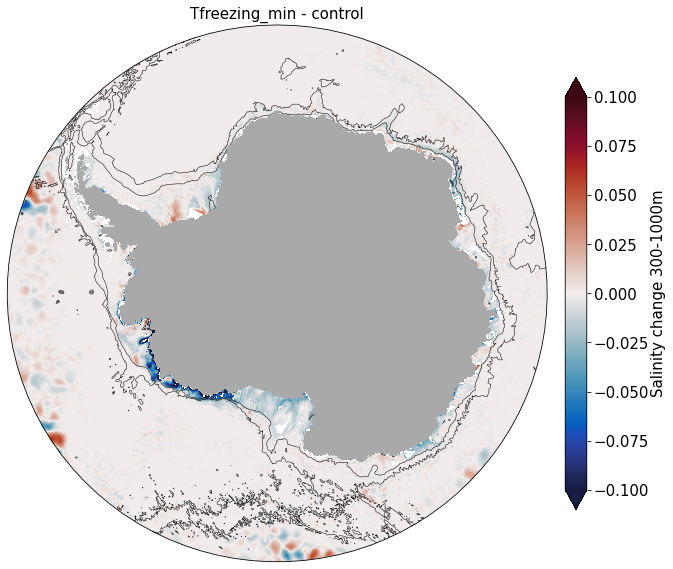

In [21]:
scale_max = .1

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# Tfreezing_insituS
# setup stereo projection:
#ax = fig.add_axes([0.0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
#theta = np.linspace(0, 2*np.pi, 100)
#center, radius = [0.5, 0.5], 0.5
#verts = np.vstack([np.sin(theta), np.cos(theta)]).T
#circle = mpath.Path(verts * radius + center)
#ax.set_boundary(circle, transform=ax.transAxes)
## plot:
#cf = ax.pcolormesh(avet_avek_diff_salt_Tfreezing_insituS.xt_ocean, avet_avek_diff_salt_Tfreezing_insituS.yt_ocean, avet_avek_diff_salt_Tfreezing_insituS, norm = norm, 
#                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
#ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
#plt.title('Tfreezing_insituS',fontsize=fontsize)
#ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
#             zorder=2,transform = ccrs.PlateCarree())
#ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# Tfreezing_zeroS
#ax = fig.add_axes([0.31, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
#theta = np.linspace(0, 2*np.pi, 100)
#center, radius = [0.5, 0.5], 0.5
#verts = np.vstack([np.sin(theta), np.cos(theta)]).T
#circle = mpath.Path(verts * radius + center)
#ax.set_boundary(circle, transform=ax.transAxes)
## plot:
#cf = ax.pcolormesh(avet_avek_diff_salt_Tfreezing_zeroS.xt_ocean, avet_avek_diff_salt_Tfreezing_zeroS.yt_ocean, avet_avek_diff_salt_Tfreezing_zeroS, norm = norm, 
#                   cmap = cmocean.balance,transform = ccrs.PlateCarree())
#ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
#plt.title('Tfreezing_zeroS',fontsize=fontsize)
#ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
#             zorder=2,transform = ccrs.PlateCarree())
#ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# Tfreezing_min
ax = fig.add_axes([0.62, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(avet_avek_diff_salt_Tfreezing_min.xt_ocean, avet_avek_diff_salt_Tfreezing_min.yt_ocean, avet_avek_diff_salt_Tfreezing_min, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Tfreezing_min - control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.93, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Salinity change 300-1000m',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

In [16]:
temp_con = cc.querying.getvar(control, 'temp', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)

#temp_Tfreezing_insituS = cc.querying.getvar(Tfreezing_insituS, 'temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
#temp_Tfreezing_insituS = temp_Tfreezing_insituS.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)

#temp_Tfreezing_zeroS = cc.querying.getvar(Tfreezing_zeroS, 'temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
#temp_Tfreezing_zeroS = temp_Tfreezing_zeroS.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)

temp_Tfreezing_min = cc.querying.getvar(Tfreezing_min, 'temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_Tfreezing_min = temp_Tfreezing_min.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)

In [17]:
#diff_temp_Tfreezing_insituS = temp_Tfreezing_insituS[:,34:43,:,:] - temp_con[:,34:43,:,:]
#diff_temp_Tfreezing_zeroS = temp_Tfreezing_zeroS[:,34:43,:,:] - temp_con[:,34:43,:,:]
diff_temp_Tfreezing_min = temp_Tfreezing_min[:,34:43,:,:] - temp_con[:,34:43,:,:]

In [18]:
#avek_diff_temp_Tfreezing_insituS = diff_temp_Tfreezing_insituS.mean('st_ocean')
#avek_diff_temp_Tfreezing_zeroS = diff_temp_Tfreezing_zeroS.mean('st_ocean')
avek_diff_temp_Tfreezing_min = diff_temp_Tfreezing_min.mean('st_ocean')

In [19]:
#avet_avek_diff_temp_Tfreezing_insituS = avek_diff_temp_Tfreezing_insituS.mean('time')
#avet_avek_diff_temp_Tfreezing_zeroS = avek_diff_temp_Tfreezing_zeroS.mean('time')
avet_avek_diff_temp_Tfreezing_min = avek_diff_temp_Tfreezing_min.mean('time')

2022-08-10 10:41:11,755 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-08-10 10:41:13,087 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-08-10 10:41:19,206 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


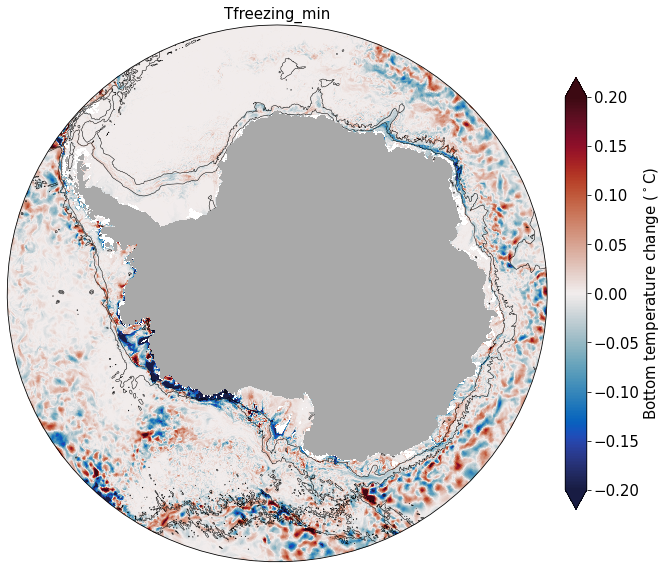

In [22]:
scale_max = .2

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# Tfreezing_insituS
# setup stereo projection:
#ax = fig.add_axes([0.0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
#theta = np.linspace(0, 2*np.pi, 100)
#center, radius = [0.5, 0.5], 0.5
#verts = np.vstack([np.sin(theta), np.cos(theta)]).T
#circle = mpath.Path(verts * radius + center)
#ax.set_boundary(circle, transform=ax.transAxes)
## plot:
#cf = ax.pcolormesh(avet_avek_diff_temp_Tfreezing_insituS.xt_ocean, avet_avek_diff_temp_Tfreezing_insituS.yt_ocean, avet_avek_diff_temp_Tfreezing_insituS, norm = norm, 
#                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
#ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
#plt.title('Tfreezing_insituS',fontsize=fontsize)
#ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
#             zorder=2,transform = ccrs.PlateCarree())
#ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# Tfreezing_zeroS
#ax = fig.add_axes([0.31, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
#theta = np.linspace(0, 2*np.pi, 100)
#center, radius = [0.5, 0.5], 0.5
#verts = np.vstack([np.sin(theta), np.cos(theta)]).T
#circle = mpath.Path(verts * radius + center)
#ax.set_boundary(circle, transform=ax.transAxes)
## plot:
#cf = ax.pcolormesh(avet_avek_diff_temp_Tfreezing_zeroS.xt_ocean, avet_avek_diff_temp_Tfreezing_zeroS.yt_ocean, avet_avek_diff_temp_Tfreezing_zeroS, norm = norm, 
#                   cmap = cmocean.balance,transform = ccrs.PlateCarree())
#ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
#plt.title('Tfreezing_zeroS',fontsize=fontsize)
#ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
#             zorder=2,transform = ccrs.PlateCarree())
#ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# Tfreezing_min
ax = fig.add_axes([0.62, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(avet_avek_diff_temp_Tfreezing_min.xt_ocean, avet_avek_diff_temp_Tfreezing_min.yt_ocean, avet_avek_diff_temp_Tfreezing_min, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Tfreezing_min',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.93, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Bottom temperature change ($^\circ$C)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)